<center>
    <h1> ILI285 - Computación Científica I  / INF285 - Computación Científica </h1>
    <h2> Tarea 2 </h2>
    <h2> [S]cientific [C]omputing [T]eam </h2>
</center>

_Marzo 2017_

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from table import Table
%matplotlib inline

# Tabla de Contenidos
* [1.- Introducción](#intro)
* [2.- Aritmética Punto Flotante](#aritmetica)
* [3.- Pérdida de Significancia](#perdida)
* [4.- Conclusiones](#res)
* [5.- Referencias](#ref)

<div id='intro' />
# 1. Introducción

En este trabajo se estudiará el estándar IEEE 754, para analizar sus falencias como la pérdida de significancia, para aprender a sobrellevar adaptando nuestros problemas y lograr mejores resultados computacionales.

In [59]:
import bitstring as bs

def pack_binary(f):
    b = bs.pack('>d', f)
    b = b.bin
    return b[0], b[1:12], b[12:]

def to_binary(f):
    return ' '.join(pack_binary(f))

def next_float(f):
    b = bs.pack('>d', f)
    m = b[12:].uint
    m += 1
    b[12:] = m
    return b.float

<div id='aritmetica' />
2. Aritmética de Punto Flotante
-------------------------------

El estándar IEEE consiste en un set de representaciones binarias de numeros reales, en donde la precisión denominada *double precision* se estructuran de la siguiente forma: el **signo** ( + o - ) que ocupa 1 bit, una **mantisa** $b$ , que contiene un string the bits significantes, usando un total de 52 bits y el **exponente** $p$, que ocupa 11 bits. La representación normalizada de los números de punto flotante es la siguiente:

$$ \pm1.bbb...b \times 2^p$$

a)  Defina que corresponde el valor de **machine epsilon** $\epsilon_{mach}$ y explique porqué es posible obtener dicho valor en una computadora IEEE de doble precisión calculando el valor de la siguiente resta:

$$\left(\frac{7.0}{3.0} - \frac{4.0}{3.0}\right) - 1.0 $$

Implemente la resta usando variables de doble precisión y describa el procedimiento usando aritmética de doble precisión y Nearest Rounding Rule



Claramente vemos un error de pérdida de precisión, matemáticamente el resultado debería ser 0, por lo que intentaremos ver que pasa realmente cuando intentamos hacer la resta:

$$(\frac{7.0}{3.0} - \frac{4.0}{3.0})$$

Dado que esta no está entregando el valor esperado $1$.

En representación binaria, la resta se vería como:

In [38]:
print("  " + to_binary(7.0/3.0))
print("- " + to_binary(4.0/3.0))
print("  " + to_binary(0.0).replace("0", "-"))
print("= " + to_binary(7.0/3.0 - 4.0/3.0))

  0 10000000000 0010101010101010101010101010101010101010101010101011
- 0 01111111111 0101010101010101010101010101010101010101010101010101
  - ----------- ----------------------------------------------------
= 0 01111111111 0000000000000000000000000000000000000000000000000001


Para restar floats IEEE 754 debemos correr la coma hasta lograr el mismo exponente en ambos números:

In [39]:
def shift_right(b, places):
    sign, exp, mantissa = b
    exp = bin(int(exp, 2) + places)[2:]
    exp = (11 - len(exp)) * "0" + exp
    return sign, exp, "0"*(places - 1) + "1" + mantissa[:(52 - places)]

print("  " + to_binary(7.0/3.0))
print("- " + " ".join(shift_right(pack_binary(4.0/3.0), 1)))
print("  " + to_binary(0.0).replace("0", "-"))
print("= " + to_binary(7.0/3.0 - 4.0/3.0))

  0 10000000000 0010101010101010101010101010101010101010101010101011
- 0 10000000000 1010101010101010101010101010101010101010101010101010
  - ----------- ----------------------------------------------------
= 0 01111111111 0000000000000000000000000000000000000000000000000001


Por lo anterior, notamos que al hacer _shift_, redondear, restar los valores de puntos flotantes y normalizar perdemos información sobre los valores menos significativos, lo que resultará en que el valor final no sea exactamente $1$, si no que el valor siguiente a $1$ representable por este estándar.

b) Considere la serie geométrica:

$$\sum_{i=0}^{\infty} r^i = \frac{1}{1-r}$$ 

para $|r|<1$. Ahora considere el siguiente código.

In [40]:
# Suma parcial de serie geométrica.
# Esta función realiza una suma parcial de la serie geométrica con M terminos, 
# pero detecta si es que los terminos que se están agregando aportan o no al
# resultado final. En caso de que los terminos ya no aporten, se detiene el loop
# y se retorna el valor obtenido y el índice en que se detuvo el loop.

def my_partial_geometric_series(r, M):
    sum_final = 1.0
    sum_before = sum_final
    final_index = -1
    for i in np.arange(1, M):
        sum_before += r**i
        if sum_final == sum_before:
            final_index = i - 1
            break
        else:
            sum_final = sum_before
    # Se retorna el valor obtenido de la suma parcial y cuando se truncó
    # dado que no aportaba.
    return np.array([sum_final, final_index])

Ahora para distintos valores de $r$ se han obtenido el número de terminos que efectivamente aportan al resultado final dado que se está utilizando _double precision_.

In [41]:
N = 20
M = 1e8
r_all = np.logspace(-1, -20, N)
out_data = np.zeros((N, 2))

for i in np.arange(N):
    out_data[i, :] = my_partial_geometric_series(r_all[i], M)

Graficando la candidad de terminos significativos en _double precision_ versus el $r$.

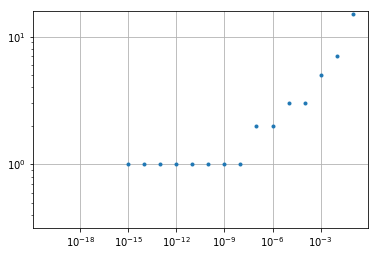

In [42]:
plt.figure()
plt.loglog(r_all, out_data[:, 1], '.')
plt.grid(True)
plt.ylim([10**(-0.5), np.max(out_data[:, 1]) + 1])
plt.show()

Explique cláramente por qué a medida que disminuye $r$ disminuye la cantidad de terminos significativos obtenidos.


Es claro ver que al tener valores de $r$ cada vez más bajos, nuestra suma requerirá poder representar valores en la mantisa cada vez más pequeños, eventualmente nos encontraremos con valores tan pequeños que saldrán de la mantisa, siendo víctimas de la regla del redondeo.

En el siguiente gráfico se podrá ver cómo se explica la perdida de nuestra representación, en términos de cada iteración.

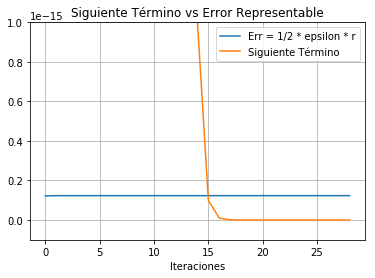

In [43]:
import sys
epsilon = sys.float_info.epsilon

def my_partial_geometric_series_2(r, M):
    sum_before = 1.0
    for i in np.arange(1, M):
        sum_before += r**i
        yield [sum_before, i - 1]

r = r_all[0]
results = list(my_partial_geometric_series_2(r, 30))

terms = []
errs = []
for t, i in results:
    terms.append(r**(i + 1))
    errs.append(t * epsilon / 2)

plt.figure()
plt.grid(True)
plt.plot(np.arange(29), errs, label='Err = 1/2 * epsilon * r')
plt.plot(np.arange(29), terms, label='Siguiente Término')
plt.ylim(- 1e-16, 1e-15)
plt.title('Siguiente Término vs Error Representable')
plt.legend()
plt.xlabel('Iteraciones')
plt.show()

En el gráfico anterior vemos que en la iteración $15$, con $r = 0.1$, corta al eje que nos indica si el error escalado permite representar los valores menores sumados, es decir:

$$|fl(x) - x| < \frac{1}{2} * \epsilon * x$$

Al tener valores sumados que son menores a este rango, no afectarán la suma final.

**C)** Explique la razón de por qué el loop indicado debe ejecutar el break. Utilice la función "to_binary" incluida en el jupyter notebook "03_floating_point_arithmetic" para entregar su justificación. Obtenga el menor valor de $X$ que ejecuta el break.

In [44]:
X = 9007199254740991.0
a = X + 0.0
b = X + 1.0

while(True):
    a += 1.0
    b += 1.0

    if a == b:
        print('They are equal! Why?')
        break

They are equal! Why?


Con el código modificado se ve que encontramos un valor que termina el loop inmediatamente, este valor fue encontrado analizando cual sería la condición para que exista una igualdad en nuestra representación:

Para que $x$ aumente en valor, debe cumplir al menos:
$$
x + 1 \geq \frac{\epsilon_{mach}}{2} x + x
$$

Para que $y$ no sea afectado por esta suma, debe cumplir:
$$
y + 1 < \frac{\epsilon_{mach}}{2} y + y
$$

Podemos expresar $y$ en términos de $x$ si consideramos que $x$ es aumentado por la primera inecuación:
$$
y = x + \epsilon_{mach} \cdot x
$$

Transformando:
$$
x + \epsilon_{mach} \cdot x + 1 < \frac{\epsilon_{mach}}{2} (x + \epsilon_{mach} \cdot x) + x + \epsilon_{mach} \cdot x
$$

Al trabajar ambas ecuaciones, llegamos a:
$$
x \leq \frac{2}{\epsilon_{mach}} \Rightarrow x \leq 9007199254740992.0
$$

$$
1 < x \left( \frac{e}{2} + \frac{e^2}{2} \right) \Rightarrow x > 9007199254740990.0
$$

Convenientemente, llegamos a que nuestro valor requerido es $9007199254740991.0$, lo que logra que la iteración sólo se ejecute una vez.

<div id='perdida' />
3. Perdida de Significancia
---------------------------

La **Pérdida de Significancia** ocurre cuando en un cálculo numérico muchos dígitos relevantes se cancelan, dada la aritmética de punto flotante finita ocupada por los computadores. Cuando un número es restado por otro número considerablemente parecido, efectos indeseados ocurren tales como la cancelación  y reducción de dígitos.

#### 1. Dada la función:

$$f(x) = \frac{1 - x}{ 1 + x} - \frac{1}{3x+1}$$

a) Grafique la función usando $x \in {[-10,10]}$ ¿Para que valores de x la función queda reducida a $0$?

In [45]:
def f(x):
    return (1 - x)/(1 + x) - 1/(3 * x + 1)
f = np.vectorize(f)

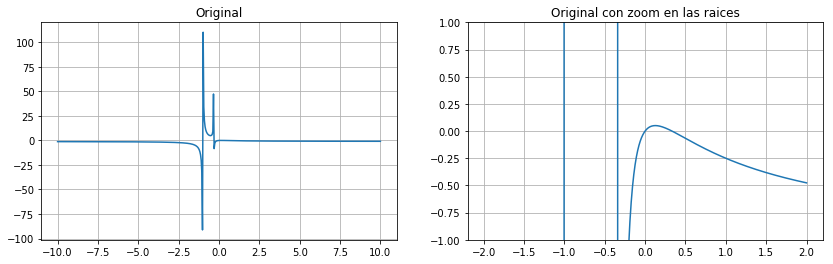

In [46]:
plt.figure(figsize=(14, 4))

xs = np.linspace(-10, 10, 500)
ys = f(xs)

plt.subplot(1, 2, 1)
plt.title("Original")
plt.grid(True)
plt.plot(xs, ys)

xs = np.linspace(-2, 2, 500)
ys = f(xs)

plt.subplot(1, 2, 2)
plt.ylim(-1, 1)
plt.title("Original con zoom en las raices")
plt.grid(True)
plt.plot(xs, ys)

plt.show()

Se puede ver gráficamente las raíces de la función en $0$ y $\frac{1}{3}$. Además vemos analíticamente que la función se indefine en $-1$ y $-\frac{1}{3}$ dados los denominadores.

b) Usando $x = [10^{-1} , 10^{-2} , ... , 10^{-20}]$, calcule los valores de f(x) ¿Que ocurre con los valores observados? ¿En que momento ocurre pérdida de significancia? Describa el origen de cancelación de digítos. 

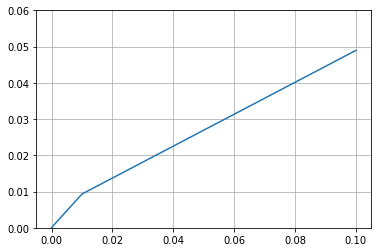

In [47]:
xs = np.logspace(-1, -20, 20)
ys = f(xs)

plt.figure()
plt.grid(True)
plt.ylim(0, 0.06)
plt.plot(xs, ys)
plt.show()

Para saber si estamos perdiendo significancia analizaremos un momento en la fórmula en que no se puedan representar más términos, efectivamente retornando el mismo resultado de la operación anterior.

In [48]:
table = Table(['x', 'bin(f(x))', 'f(x)', ' '])

prev = 0
for i in xs:
    r = f(i)
    table += [i, to_binary(r), r, ('!' if r == prev else " ")]
    prev = r

print(table)

| x      | bin(f(x))                                                          | f(x)                   |   |
|--------|--------------------------------------------------------------------|------------------------|---|
|    0.1 | 0 01111111010 1001000100000001110010100100101100110000010101100000 |    0.04895104895104896 |   |
|   0.01 | 0 01111111000 0011000110001001010101101011111010000100011100000000 |   0.009324233394213177 |   |
|  0.001 | 0 01111110101 0000010001010000110001100011111001001100110000000000 |  0.0009930249212402043 |   |
| 0.0001 | 0 01111110001 1010001100100011000011000001110001010110000000000000 |   9.99300249920898e-05 |   |
|  1e-05 | 0 01111101110 0100111110000101010101010100101101010000000000000000 |  9.999300024987612e-06 |   |
|  1e-06 | 0 01111101011 0000110001101110111111101110011000000000000000000000 |   9.99992999961563e-07 |   |
|  1e-07 | 0 01111100111 1010110101111111000101011111000000000000000000000000 |  9.999992989229156e-08 |   |
|  1e-08 | 0 011111

En la tabla anterior notamos que al llegar a $1e-18$, comenzamos a obtener un resultado identico al resultado anterior, como se puede apreciar en la representación binaria del resultado, esto se explica ya que nuestras operaciones intentarán representar números no representables, por lo que se redondearán. Por ejemplo en una fórmula más sencilla $1 + x$ comenzaremos a "sumar 0", lo que es producido al intentar sumar un número menor que $\frac{1}{2} \cdot e_{mach}$, lo que en IEEE 754, al redondear, queda en $1$.

c) Reescriba la función original para evitar el proceso de pérdida de significancia (hint: busqué un denominador común para ambas fracciones.)

$$\frac{x - 3 \cdot x^2}{1 + 4 \cdot x + 3 \cdot x^2}$$

In [49]:
def k(x):
    return (x - 3 * x**2)/(1 + 4 * x + 3 * x**2)
k = np.vectorize(k)

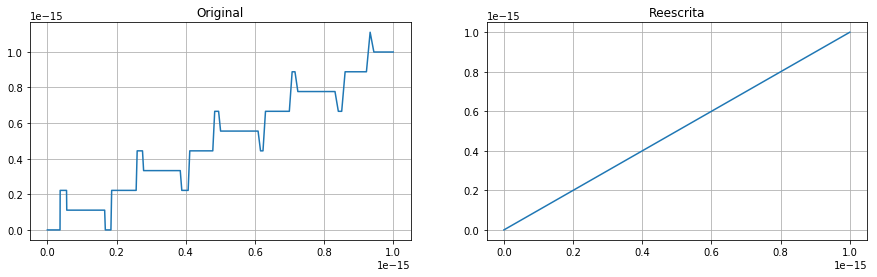

In [50]:
def plot(f, xs, title, grid):
    plt.subplot(1, 2, grid)
    plt.title(title)
    plt.grid(True)
    plt.plot(xs, f(xs))

xs = np.logspace(-15, -20, 1000)
plt.figure(figsize=(15, 4))
plot(f, xs, "Original", 1)
plot(k, xs, "Reescrita", 2)
plt.show()

Notamos que la función original, al perder precisión, nos presenta valores cercanos al resultado esperado, pero con errores, mientras que la función reescrita parece evitar estos errores (en la escala representada en el gráfico), lo que no significa que no pierda presición, si no que convenientemente pierde menos.

d) Analice la diferencia entre los resultados de la función $f(x)$ con la función reescrita en la pregunta anterior. Realice un gráfico que mida la diferencia entre los resultados del punto a) y c). Realice un análisis cualitativo y cuantitativo de los resultados.

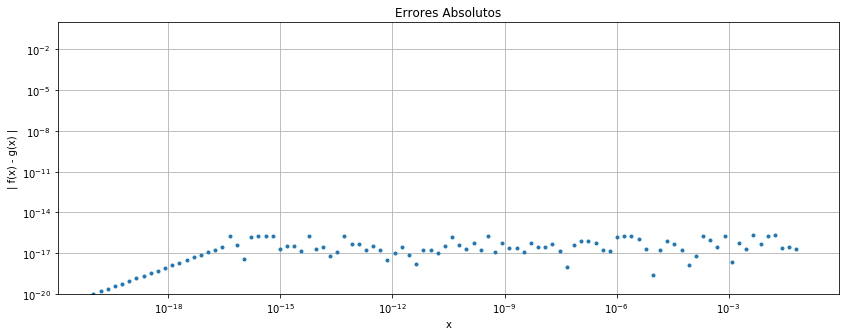

In [51]:
xs = np.logspace(-20, -1, 100)

ys1 = f(xs)
ys2 = k(xs)
errs = np.abs(ys1 - ys2)

plt.figure(figsize=(14, 5))
plt.title('Errores Absolutos')
plt.loglog(xs, errs, '.')
plt.ylim(0, 1)
plt.xlabel('x')
plt.ylabel('| f(x) - g(x) |')
plt.grid(True)
plt.show()

Vemos que en un principio nuestra función reescrita logra representar correctamente valores cercanos a $0$, luego el error tiende a ser al rededor de $10^{-16}$, y esto se explica por la pérdida que tiene nuestra representación IEEE 754, donde las operaciones de suma y resta con valores distantes por $10^{-16}$ órdenes de magnitud no afectarán al resultado.

#### 2. Para la siguiente función: 

$$g(x) = \frac{1 - \sec(x)}{\tan(x)^2} $$

a) Usando $x = [0,\frac{\pi}{4} ,\frac{\pi}{2}, \frac{3\pi}{4} , ... , 2\pi ]$ (intervalo de $0$ a $2\pi$ ) calcule los valores de esta función. Realice el mismo procedimiento del punto anterior.

In [52]:
def g(x):
    return (1 - 1 / np.cos(x))/(np.tan(x)**2)
g = np.vectorize(g)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


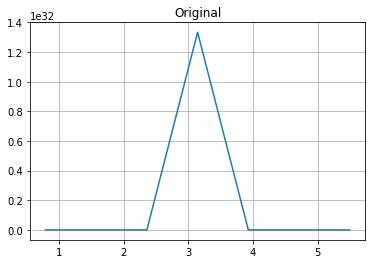

In [53]:
xs = np.arange(0, 2 * np.pi, np.pi/4)
ys = g(xs)

plt.figure()
plt.title("Original")
plt.grid(True)
plt.plot(xs, ys)
plt.show()

De la forma que escribimos la función, encontramos problemas de indeterminación en $x = 0$, los puntos son:

In [54]:
table = Table(['x', 'y'])
for x, y in zip(xs, ys):
    table += [x, y]
print(table)

| x              | y                  |
|----------------|--------------------|
|            0.0 |                nan |
| 0.785398163397 |    -0.414213562373 |
|  1.57079632679 | -6.12323399574e-17 |
|  2.35619449019 |      2.41421356237 |
|  3.14159265359 |  1.33354689406e+32 |
|  3.92699081699 |      2.41421356237 |
|  4.71238898038 |  1.83697019872e-16 |
|  5.49778714378 |    -0.414213562373 |


Analizando números cercanos a $0$, vemos que tenemos problemas con nuestra representación, en el rango $x = [10^{-1} , 10^{-2} , ... , 10^{-20}]$

In [55]:
xs = np.logspace(-1, -20, 20)

table = Table(['x', 'bin(f(x))', 'f(x)', ' '])
prev = 0
for i in xs:
    r = g(i)
    table += [i, to_binary(r), r, "!" if r == prev else " "]
    prev = r
print(table)

| x      | bin(f(x))                                                          | f(x)                 |   |
|--------|--------------------------------------------------------------------|----------------------|---|
|    0.1 | 1 01111111101 1111111010110111110001011110100101011010111110010101 |  -0.4987479137114346 |   |
|   0.01 | 1 01111111101 1111111111111100101110010010000000001011001110010111 | -0.49998749979095564 |   |
|  0.001 | 1 01111111101 1111111111111111111101111001110011000011000010000001 |  -0.4999998750142894 |   |
| 0.0001 | 1 01111111101 1111111111111111111111111001001010000111010110000101 |  -0.4999999936279312 |   |
|  1e-05 | 1 01111111110 0000000000000000000000010110001100010100101100101111 |   -0.500000041336852 |   |
|  1e-06 | 1 01111111110 0000000000000101110100111000000100010111010001000110 |  -0.5000444502908372 |   |
|  1e-07 | 1 01111111110 0000010101111010110011110101111101110111111111100010 |  -0.5107025913275687 |   |
|  1e-08 | 0 00000000000 000000000000

Como vemos en la tabla anterior, al llegar a $10^{-8}$ perdemos significancia, por lo que todos los siguiente valores no representarán un resultado confiable.

Para evitar errores, reescribimos nuestra fórmula como:

$$
\frac{1}{cos(x) + 1} - 1
$$

y analizamos números cercanos a $0$ para descubrir el error que provocaría esta nueva función.

In [56]:
def h(x):
    return 1 / (np.cos(x) + 1) - 1
h = np.vectorize(h)

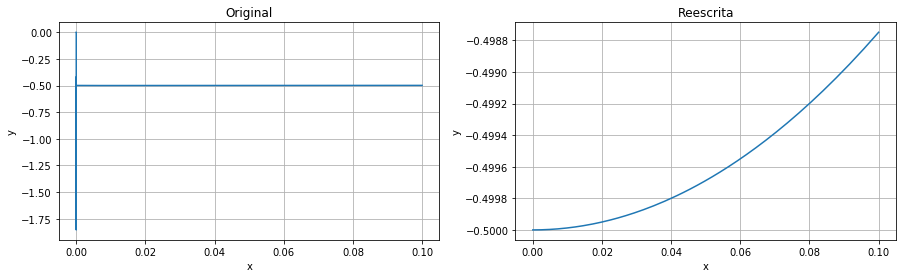

In [57]:
def plot(f, xs, title, grid):
    plt.subplot(1, 2, grid)
    plt.title(title)
    plt.grid(True)
    plt.ylabel('y')
    plt.xlabel('x')
    plt.plot(xs, f(xs))

xs = np.logspace(-1, -20, 1000)
plt.figure(figsize=(15, 4))
plot(g, xs, "Original", 1)
plot(h, xs, "Reescrita", 2)
plt.show()

Como se aprecia, la nueva función no tiene los problemas de la función original, logrando representar correctamente valores cercanos a $0$, inclusive.

Finalmente, mostramos los errores absolutos, para tener en cuenta en qué valores podremos encontrar los mayores problemas:

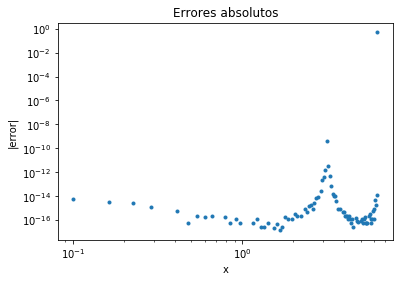

In [58]:
xs = np.linspace(0.1, 2 * np.pi, 100)
ys = np.abs(g(xs) - h(xs))

plt.figure()
plt.title('Errores absolutos')
plt.ylabel('|error|')
plt.xlabel('x')
plt.loglog(xs, ys, '.')
plt.show()

<div id="res"/>
# 4. Conclusiones

En este trabajo se estudia las falencias del estándar IEEE 754, y sobre cómo podemos adaptar nuestros métodos para encontrar los valores esperados en la realidad. Además se pueden ver las grandes diferencias de distintos métodos acotados en intervalos críticos, donde algunos resultados no nos sirven, pero otros con otro método nos ayuda a encontrar el resultado correcto.

Finalmente, se encuentra en qué momentos las fórmulas presentarán problemas, pudiendo estudiarlos a nivel binario para diagnosticar los errores.

<div id="ref"/>
# 5. Referencias

- https://www.wolframalpha.com/
- http://pages.cs.wisc.edu/~smoler/x86text/lect.notes/arith.flpt.html